In [41]:
# Librerías que se usarán

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad
from astropy import units as u
import emcee
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.optimize import minimize
import pylab as py
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from astropy import units as u
from astropy import coordinates as coords
from astroquery.skyview import SkyView
#from photutils.aperture import CircularAperture
from astropy.visualization import simple_norm
import corner

plt.rcParams['axes.grid'] = False
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams.update({"font.size": 13, "font.family": "serif"})


# Pregunta 1

In [3]:
# Importamos los datos del .csv adjunto
df_P1 = pd.read_csv('sn-data.csv')
df_P1 = df_P1.sort_values(by=['redshift'])

# Extraemos los datos en NumPy arrays
redshift = np.array(df_P1.iloc[:, 0])
dist_mod = np.array(df_P1.iloc[:, 1])
err_dist_mod = np.array(df_P1.iloc[:, 2])

df_P1.head()

,redshift,dist_mod,err_dist_mod
37,0.0150,34.111411,0.213389
48,0.0150,34.379773,0.217349
49,0.0153,34.707186,0.213243
39,0.0187,35.048300,0.197197
0,0.0192,34.491562,0.197092


<ipython-input-3-c2a05163e033>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


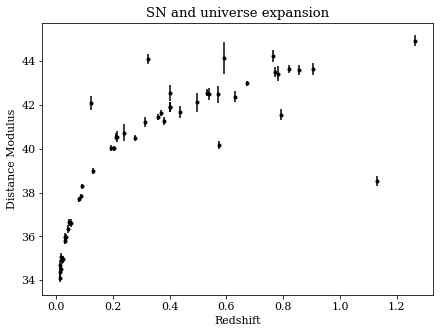

In [3]:
# Veamos cómo son los datos
fig1, ax1 = plt.subplots(figsize=(7, 5))
ax1.errorbar(redshift, dist_mod, yerr=err_dist_mod, fmt='.k')
ax1.set_xlabel('Redshift')
ax1.set_ylabel('Distance Modulus')
ax1.set_title('SN and universe expansion')
fig1.show()

Notamos que al parecer hay outlayers para los valores más grandes de redshift (que se encuentran más lejos) y que la relación al parecer tiene una tendencia siempre creciente, aunque disminuyendo la tasa de crecimiento para redshift más grandes.\\

A simple vista podría fitearse con una relación de la forma $f(x)=\sqrt x$ o una porción de un polinomio de grado $n$

## P1. a)

### Primer intento P1. a)

In [4]:
# Separamos los datos en train (para entrenar nuestro algoritmo) y test para testear el modelo
X_train, X_test, y_train, y_test = train_test_split(redshift, dist_mod, test_size=0.33, random_state=10)

In [5]:
# Listas para guardar los RMS
rms_test_list = []
rms_train_list = []
# Array para guardar los parámetros finales
estParms_2D = np.zeros((10, 12))

for i in range(0, 10):
  """
  Intentamos modelos polinomiales desde grado 0 a grado 9.
  """

  def polynomial(params):
      yPred = np.zeros((len(X_train)))
      for j in range(0, i+1):
        # Con este bucle for creamos el polinomio de grado i
        yPred += params[j]*X_train**int(j)

      # Calculamos el logaritmo negativo del likelihood
      LL = -np.sum(stats.norm.logpdf(y_train, loc=yPred))

      return(LL)


  # Como parámetros iniciales usamos todo igual a 1
  initParams = np.ones((i+1))

  # Minimizamos el logaritmo negativo del likelihood variando los parámetros
  results = minimize(polynomial, initParams, method='Nelder-Mead')

  estParms = results.x  # parámetros finales

  estParms_2D[i, :i+1] = estParms[:i+1]  # guardamos los parámetros finales

  # Arreglos para guardar las predicciones del modelo
  yOut_test = np.zeros((len(X_test)))
  yOut_train = np.zeros((len(X_train)))

  for j in range(0, i+1):
    # Obtenemos los resultados predichos para X_test y X_train
    yOut_test += estParms[j]*X_test**(int(j))
    yOut_train += estParms[j]*X_train**(int(j))

  # Guardamos los RMS y los agregamos a las listas vacías
  rms_test = np.sqrt(mean_squared_error(y_test, yOut_test))
  rms_train = np.sqrt(mean_squared_error(y_train, yOut_train))

  rms_test_list.append(rms_test)
  rms_train_list.append(rms_train)

  #print ('Para el polinomio de grado', i, 'los parámetros son: ', estParms)


<ipython-input-6-6cf739452769>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


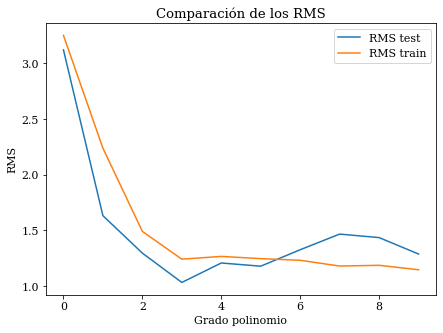

In [6]:
fig2, ax2 = plt.subplots(figsize=(7, 5))
ax2.plot(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8,9]), rms_test_list, label='RMS test')
ax2.plot(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8,9]), rms_train_list, label='RMS train')
ax2.set_title('Comparación de los RMS')
ax2.set_xlabel('Grado polinomio')
ax2.set_ylabel('RMS')
ax2.legend()
fig2.show()

Como podemos ver en el gráfico de arriba, el RMS del set train tiende siempre a la disminución, mientras que el RMS del set test comienza disminuyendo, alcanzando su mínimo en el grado $n=3$ donde comienza a aumentar. Como conseguimos el menor RMS usando un polinomio de grado 3, nos quedamos con este grado para hacer el fit de los datos.

Veamos cómo se ve este modelo comparado con los datos

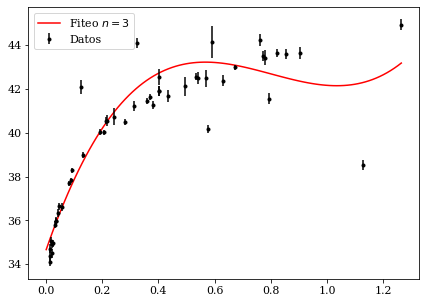

In [7]:
# Ploteamos en todo el rango de redshift
x_plot = np.linspace(0, np.max(redshift), 100)

# Calculamos el arreglo con los datos predichos con los parámetros finales con n=3
testing = estParms_2D[3, 3]*x_plot**3 + estParms_2D[3, 2]*x_plot**2 + estParms_2D[3, 1]*x_plot + estParms_2D[3, 0]

# Plot
fig3, ax3 = plt.subplots(figsize=(7, 5))
ax3.plot(x_plot, testing, label='Fiteo $n=3$', color='red')
ax3.errorbar(redshift, dist_mod, yerr=err_dist_mod, fmt='.k', label='Datos')
ax3.legend()

In [8]:
estParms_2D[3, :]

array([ 34.66708245,  36.9415292 , -50.42792607,  20.9863059 ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

## P1. b)

In [36]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import RidgeCV
X, y = load_diabetes(return_X_y=True)
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X, y)
clf.score(X, y)

0.5166287840315831

In [47]:
len(X)

442

In [38]:
y_pred=clf.predict(X)

array([204.30324008,  69.68600206, 175.22187635, 164.6597524 ,
       128.23867015, 105.73535189,  77.21946172, 121.57007705,
       159.31851016, 213.18741742,  99.42856179, 101.23084798,
       114.80847861, 162.76883194, 102.27544379, 174.7726148 ,
       209.51670809, 182.23487077, 146.86561085, 122.65445219,
       119.08758001,  89.50385419, 116.33717225, 265.72345543,
       164.03700391, 145.79026763,  96.68176523, 177.98394823,
       127.95128615, 183.55022744, 158.86498565,  69.59667632,
       257.27008944, 108.94124894,  80.05043639,  85.12957427,
       206.47812632, 155.27953569, 241.57381353, 136.11010577,
       153.57965855,  74.02848707, 144.15154599,  78.90306881,
       218.30760284, 124.4782497 , 140.5475606 , 107.73561017,
        76.45948512, 186.93051945, 157.50464005, 167.92394722,
       133.75078853, 157.75403489, 140.35101701,  74.03752195,
       205.35950246,  79.95832119,  98.66460064, 134.33846834,
       114.57897492, 177.07131046,  65.49834471, 100.09

In [46]:
len(y)

442

In [49]:
plt.scatter(X.reshape((len(y))), y)
plt.scatter(X[0], y_pred)

ValueError: cannot reshape array of size 4420 into shape (442,)

### Primer intento P1. b)

In [27]:
poly_reg_ridge = PolynomialFeatures(degree=3)
x_poly_ridge = poly_reg_ridge.fit_transform(X_train.reshape(-1, 1))
r = RidgeCV(alphas=np.arange(0.001,1,0.01),fit_intercept=False)
r.fit(x_poly_ridge, y_train)

RidgeCV(alphas=array([0.001, 0.011, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081,
       0.091, 0.101, 0.111, 0.121, 0.131, 0.141, 0.151, 0.161, 0.171,
       0.181, 0.191, 0.201, 0.211, 0.221, 0.231, 0.241, 0.251, 0.261,
       0.271, 0.281, 0.291, 0.301, 0.311, 0.321, 0.331, 0.341, 0.351,
       0.361, 0.371, 0.381, 0.391, 0.401, 0.411, 0.421, 0.431, 0.441,
       0.451, 0.461, 0.471, 0.481, 0.491, 0.501, 0.511, 0.521, 0.531,
       0.541, 0.551, 0.561, 0.571, 0.581, 0.591, 0.601, 0.611, 0.621,
       0.631, 0.641, 0.651, 0.661, 0.671, 0.681, 0.691, 0.701, 0.711,
       0.721, 0.731, 0.741, 0.751, 0.761, 0.771, 0.781, 0.791, 0.801,
       0.811, 0.821, 0.831, 0.841, 0.851, 0.861, 0.871, 0.881, 0.891,
       0.901, 0.911, 0.921, 0.931, 0.941, 0.951, 0.961, 0.971, 0.981,
       0.991]),
        fit_intercept=False)

In [35]:
y_pred=r.predict(x_poly_ridge)

In [29]:
y_pred

array([42.37889879, 39.9592137 , 42.63883058, 35.32112803, 36.58203598,
       43.18462117, 42.77869341, 42.27936451, 35.55742224, 37.32078047,
       40.80608136, 40.20163473, 38.61369518, 37.56828844, 35.46145528,
       42.95009375, 43.09540443, 41.82582781, 36.29812118, 43.23643816,
       38.42912231, 42.35931958, 42.67876163, 42.9964866 , 35.92739865,
       42.89859309, 42.62862381, 41.92397023, 42.47378513, 35.32112803,
       37.68000413, 43.22961342, 35.99810699])

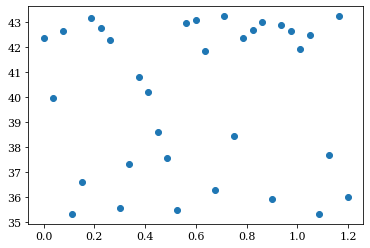

In [32]:
plt.scatter(np.linspace(0, 1.2, len(y_pred)), y_pred)

In [ ]:
clf = Ridge(alpha=2.0)
clf.fit(redshift.reshape(-1, 1), dist_mod)

Ridge()

In [ ]:
clf.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [ ]:
y_predic = clf.predict(np.linspace(0, 1.0, 40).reshape(-1, 1))

In [ ]:
y_predic

array([37.66357553, 37.82919288, 37.99481023, 38.16042758, 38.32604493,
       38.49166228, 38.65727963, 38.82289698, 38.98851434, 39.15413169,
       39.31974904, 39.48536639, 39.65098374, 39.81660109, 39.98221844,
       40.14783579, 40.31345314, 40.47907049, 40.64468784, 40.8103052 ,
       40.97592255, 41.1415399 , 41.30715725, 41.4727746 , 41.63839195,
       41.8040093 , 41.96962665, 42.135244  , 42.30086135, 42.4664787 ,
       42.63209606, 42.79771341, 42.96333076, 43.12894811, 43.29456546,
       43.46018281, 43.62580016, 43.79141751, 43.95703486, 44.12265221])

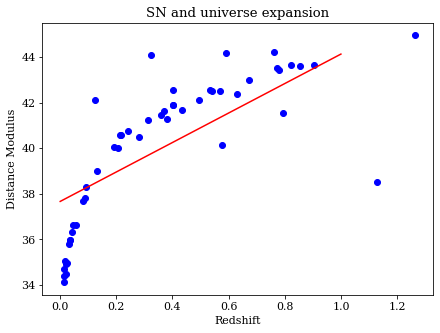

In [ ]:
fig3, ax3 = plt.subplots(figsize=(7, 5))
ax3.scatter(redshift, dist_mod, color='blue')
ax3.plot(np.linspace(0, 1.0, 40), y_predic, color='red')
ax3.set_xlabel('Redshift')
ax3.set_ylabel('Distance Modulus')
ax3.set_title('SN and universe expansion')
fig3.show()

### Segundo intento

Lo saqué de aquí https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/

In [63]:
#Import Linear Regression model from scikit-learn.

data = pd.DataFrame(np.column_stack([X_train, y_train]),columns=['x','y'])

def ridge_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    ridgereg = Ridge(alpha=alpha, normalize=True)
    ridgereg.fit(data[predictors], data['y'])
    y_pred = ridgereg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret

In [65]:
coef_matrix_ridge

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_1e-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alpha_1e-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alpha_1e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alpha_0.0001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alpha_0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alpha_0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alpha_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alpha_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alpha_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alpha_20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
#Initialize predictors to be set of 15 powers of x
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

#Set the different values of alpha to be tested
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

#Initialize the dataframe for storing coefficients.
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

models_to_plot = {1e-15:231, 1e-10:232, 1e-4:233, 1e-3:234, 1e-2:235, 5:236}
for i in range(10):
    coef_matrix_ridge.iloc[i,] = ridge_regression(data, predictors, alpha_ridge[i], models_to_plot)

KeyError: "['x_2', 'x_10', 'x_12', 'x_14', 'x_9', 'x_3', 'x_5', 'x_8', 'x_7', 'x_13', 'x_4', 'x_15', 'x_6', 'x_11'] not in index"

### Tercer intento

In [69]:
ridge_model = Ridge(alpha = 5).fit(X_train, y_train)

ValueError: Expected 2D array, got 1D array instead:
array=[0.0153     0.0187     0.216      0.5754855  0.1222895  0.042233
 0.0251     0.015      0.08901943 0.0546     0.40245962 0.08004814
 0.24       0.0931494  0.3578     0.27945473 0.401      0.0325
 0.03572    0.76308919 0.495      0.40245962 0.781      0.772
 0.045295   0.43509578 0.57       0.79233825 0.0192     1.265
 0.19214998 0.854      0.32266794].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Primer intento Lasso

In [70]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)




clf.fit([[0,0], [1, 1], [2, 2]], [0, 1, 2])

### Segundo intento Lasso

In [71]:
from sklearn import datasets
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
#
# Load the Boston Data Set
#
bh = datasets.load_boston()
X = bh.data
y = bh.target
#
# Create training and test split
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#
# Create an instance of Lasso Regression implementation
#
lasso = Lasso(alpha=1.0)
#
# Fit the Lasso model
#
lasso.fit(X_train, y_train)
#
# Create the model score
#
lasso.score(X_test, y_test), lasso.score(X_train, y_train)

(0.655906082915434, 0.6899591642958296)

### Tercer intento Lasso

In [80]:
import pandas as pd
from numpy import arange
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold

X = np.array(df_P1.iloc[:, 0]).reshape(-1, 1)
y = np.array(df_P1.iloc[:, 1])

#define cross-validation method to evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

#define model
model = LassoCV(alphas=arange(0, 10, 0.01), cv=cv, n_jobs=-1)

#fit model
model.fit(X, y)

#display lambda that produced the lowest test MSE
#print(model.alpha_)

model.coef_


/Users/javier/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/javier/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/javier/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/javier/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Use

array([7.42274819])

## P1. c)

# Pregunta 2

Para esta pregunta nos basaremos en el código usado por el profesor Valentino González. El github está [aquí.](https://github.com/thevalentino/AS450-astroinformatica)

In [4]:
def mu_Peebles(z, H_0, Omega_m, Omega_lambda):
    """
    Esta función toma como input el redshift del objeto y las constantes:
    constante de Hubble, densidad de materia y la constante cosmológica.
    Entrega el valor de la distancia en modulo calculada con el modelo
    de Peebles que se menciona en la tarea.
    """
    def integral_fn(x):
        """
        Función que calcula la integral del modelo
        """
        return 1/((Omega_m*(1 + x)**3 + Omega_lambda)**0.5)

    integral = quad(integral_fn, 0, z)[0]

    # Se especifican las unidades de las constantes
    c_united = 300000*u.km/u.second  # km/s
    H_0_united = H_0/(10**6)*u.kilometer/u.second/u.parsec

    rate = ((c_united/H_0_united).to(u.parsec)).value

    # Se returna la aproximación de la distancia al objeto
    return -5*np.log10(10) + 5*np.log10((1 + z)*rate*integral)

# Vectorizamos la función para poder aplicarla a arrays
vmu_Hubble = np.vectorize(mu_Peebles)


def ln_prior(theta):
    """
    Función que entrega 0 si los parámetros están dentro del rango esperado, y -infinito si alguno está fuera
    """
    H_0, Omega_m, Omega_lambda, Pb, Yb, logVb = theta
    if (50 < H_0 < 80) and (0 < Omega_m < 0.5) and (0 < Omega_lambda < 1) and (0 < Pb < 1) and (0 < Yb < 2000) and (-2 < logVb < 10):
        return 0
    return -np.inf


def ln_likelihood(theta, x, y, yerr):
    """
    Función que calcula el likelihood
    """
    H_0, Omega_m, Omega_lambda, Pb, Yb, logVb = theta
    Vb = 10**logVb
    model = vmu_Hubble(x, H_0, Omega_m, Omega_lambda)
    p_fg = (1-Pb) / np.sqrt(2 * np.pi * yerr**2) * np.exp(-(y-model)**2/(2 * yerr**2))
    p_bg = Pb / np.sqrt(2 * np.pi * (Vb + yerr**2)) * np.exp(-(y - Yb)**2/(2 * (Vb + yerr**2)))
    output = np.sum(np.log(p_fg + p_bg))
    return output


def ln_posterior(theta, x, y, yerr):
    """
    AGREGAR DESCRIPCIÓN
    """
    ln_p = ln_prior(theta)
    if not np.isfinite(ln_p):
        return -np.inf
    return ln_p + ln_likelihood(theta, x, y, yerr)

In [5]:
np.random.seed(6346)  # para que el cálculo sea replicable

theta_0 = np.array([71, 0.27, 0.73, 0.3, 400, 1.])  # estos son los valores de [H_0, Omega_m, Omega_lambda, Pb, Yb, logVb]
ndim, nwalkers = 6, 32

# Variamos theta_0 con una distribución al azar para cada nwalkers
pos_0 = [theta_0 + 0.1*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, 
                                args=(redshift, dist_mod, err_dist_mod), threads=8)

In [6]:
%timeit -n1 -r1 sampler.run_mcmc(pos_0, 1000);

/Users/javier/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


2min 10s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


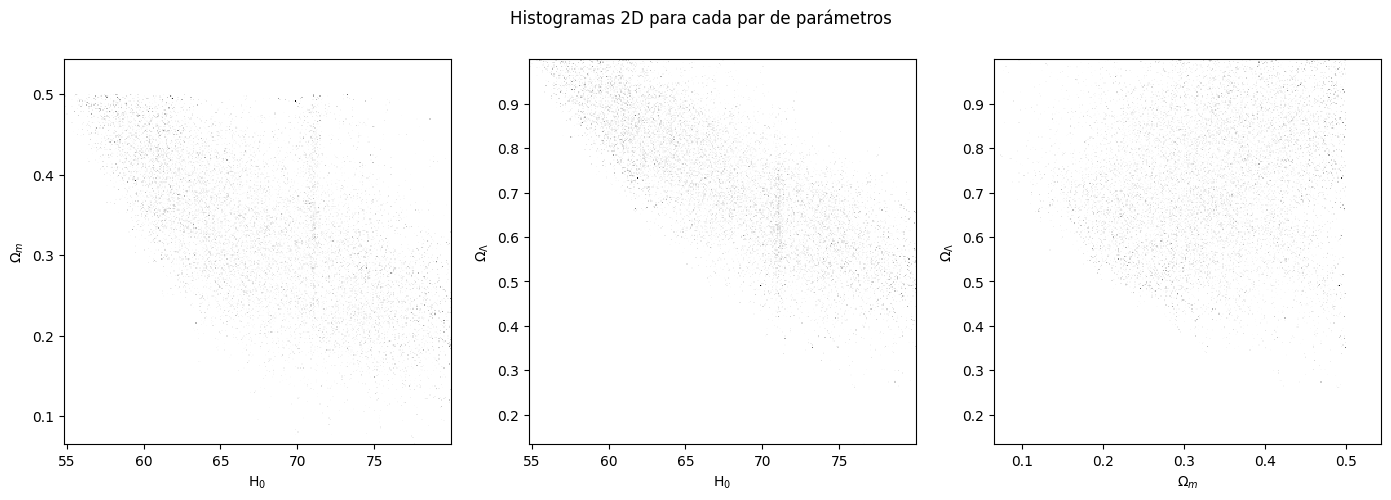

In [28]:

with plt.style.context('default'):
    fig1i, (ax11, ax12, ax13) = plt.subplots(1, 3, figsize=(17, 5))
    fig1i.suptitle('Histogramas 2D para cada par de parámetros')
    hola = ax11.hist2d(sampler.flatchain[:,0], sampler.flatchain[:,1], bins=300, 
               cmap='gray_r')
    ax11.set_xlabel('H$_0$')
    ax11.set_ylabel('$\Omega_m$')

    ax12.hist2d(sampler.flatchain[:,0], sampler.flatchain[:,2], bins=300, 
               cmap='gray_r')
    ax12.set_xlabel('H$_0$')
    ax12.set_ylabel('$\Omega_\Lambda$')

    ax13.hist2d(sampler.flatchain[:,1], sampler.flatchain[:,2], bins=300, 
               cmap='gray_r')
    ax13.set_xlabel('$\Omega_m$')
    ax13.set_ylabel('$\Omega_\Lambda$')

La regresión bayesiana nos entrega distintos sets de los 3 parámetros utilizados, que podemos graficar para analizar su comportamiento, por ejemplo, cuál es la curva donde más regresiones convergen.

Text(0.5, 1.0, 'Diferentes regresiones')

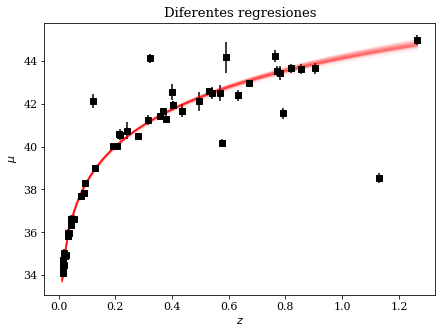

In [37]:
# Ignoramos las advertencias
import warnings
warnings.filterwarnings('ignore')

x_to_plot = np.linspace(0, np.max(redshift), 100)

fig6, ax6 = plt.subplots(figsize=(7, 5))
# Datos
ax6.errorbar(redshift, dist_mod, yerr=err_dist_mod, ls='None', marker='s', color='black')

# Gráfico de las distintas regresiones
for i in np.random.randint(0, high=len(sampler.flatchain), size=50):
    H_0, Omega_m, Omega_lambda = sampler.flatchain[i, [0, 1, 2]]
    ax6.plot(x_to_plot, vmu_Hubble(x_to_plot, H_0, Omega_m, Omega_lambda), color='red', alpha=0.05)

ax6.set_xlabel("$z$")
ax6.set_ylabel("$\mu$")
ax6.set_title('Diferentes regresiones')

Para visualizar de mejor manera las relaciones entre cada par de parámetros y las frecuencias de cada uno para los diferentes valores, ocupamos el paquete $\texttt{corner}$

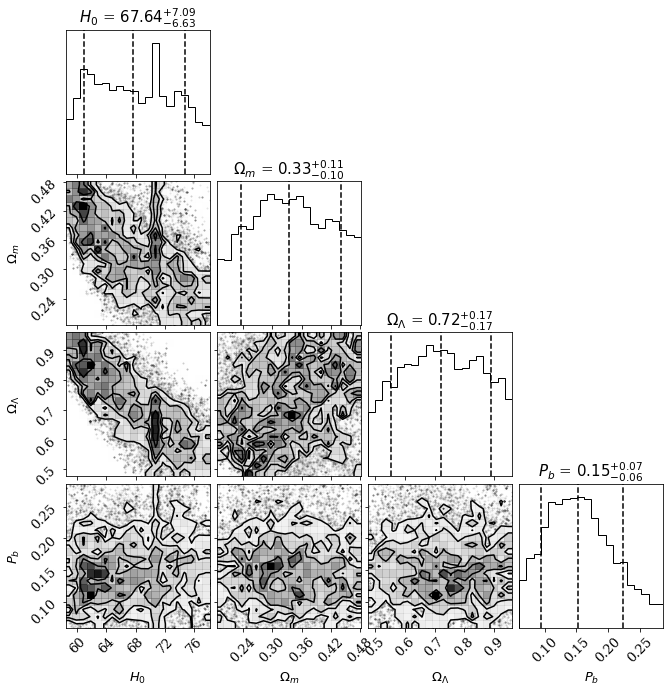

In [42]:
fig7 = corner.corner(sampler.flatchain[:,[0, 1, 2, 3]], 
                    labels=["$H_0$", "$\Omega_m$", "$\Omega_\Lambda$", "$P_b$"], 
                    range=(0.9, 0.9, 0.9, 0.9),
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 15})

# Pregunta 3

Como se sugiere en el enunciado, usamos las libreriías astropy y astroquery para descargar los datos.

In [56]:
survey = 'SDSSdr7r'

RA = coords.Longitude(angle="13:39:55.92", unit=u.hourangle)
DEC = coords.Latitude(angle="+00:50:10.02", unit=u.deg)

coordinates = coords.SkyCoord(ra=RA, dec=DEC)
width = 30  # [arcmin]
height = 30  # [arcmin]
resol = 0.3  # [arcsec]
width_pix = int(width/resol*60)
height_pix = int(width/resol*60)

In [68]:
paths = SkyView.get_images(
    position=coordinates,
    survey='SDSSdr7r',
    pixels=(width_pix, height_pix),
    width=width*u.arcmin,
    height=height*u.arcmin
)

In [69]:
data = paths[0][0].data

In [80]:
from photutils import CircularAperture

r_whirlpool = 10  # [arcmin]
norm = simple_norm(data, "sqrt", percent=99)
plt.imshow(data, norm=norm, interpolation="nearest", origin="lower")
aperture_whirlpool = CircularAperture((width_pix/2, height_pix/2), r=r_whirlpool/resol*60)
aperture_whirlpool.plot(color='w', lw=2);

TypeError: __init__() got an unexpected keyword argument 'registry'